In [1]:
import numpy as np
import matplotlib.pyplot as plt


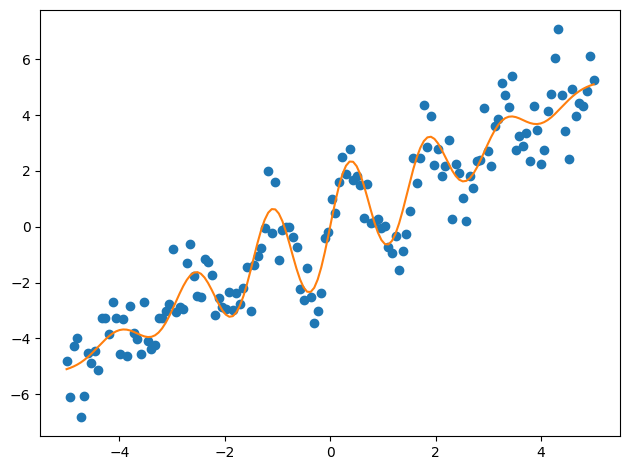

In [2]:
# Let us generate data points from a relatively complicated function
N = 150
alpha, sigma = 2., 3.
X = np.linspace(-5, 5, num=N)
y = X + (alpha * np.sin((4 * np.pi * X) / sigma) * np.exp(-(X ** 2) / (sigma ** 2)))
# Add some random noise
rng = np.random.default_rng(42)
y_noisy = y + rng.standard_normal(N)
# Show the data points
plt.plot(X, y_noisy, 'o')
plt.plot(X, y)
plt.tight_layout()

train shape: (112,)
test shape: (38,)
train y shape: (112,)
test y shape: (38,)


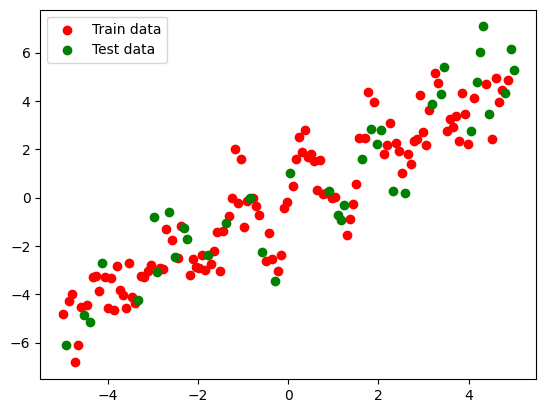

In [3]:
data = np.vstack((X, y))
# Get permuted indices
permuted_indices = rng.permutation(len(X))

# Apply the permutation to both X and y
X_permuted = X[permuted_indices]
y_permuted = y_noisy[permuted_indices]

train_ratio = 0.75
len_data = len(X)
train_size = int(len_data * train_ratio)
X_train = X_permuted[:train_size].flatten()
X_test = X_permuted[train_size:].flatten()
y_train = y_permuted[:train_size].flatten()
y_test = y_permuted[train_size:].flatten()

print(f"train shape: {X_train.shape}")
print(f"test shape: {X_test.shape}")
print(f"train y shape: {y_train.shape}")
print(f"test y shape: {y_test.shape}")

plt.scatter(X_train, y_train, color='red', label='Train data')
plt.scatter(X_test, y_test, color='green', label='Test data')
plt.legend()
plt.show()

GeneticNN(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
500
500


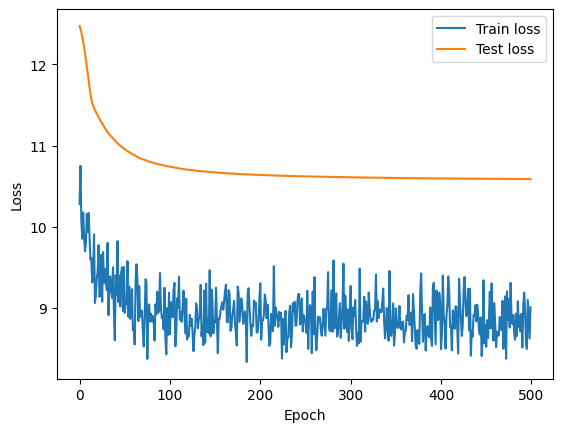

In [4]:
from model import GeneticNN
import torch

DNA = [1, 1, 1]
model = GeneticNN(DNA)
print(model)

criterion = torch.nn.MSELoss() #@param
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #@param
epochs = 500 #@param

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDataset and DataLoader for training and testing
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train the model
train_losses, test_losses = model.train_model(train_loader, test_loader, criterion, optimizer, epochs)


print(len(train_losses))
print(len(test_losses))

plt.plot([ i for i in range(len(train_losses)) ], train_losses, label='Train loss')
plt.plot([ i for i in range(len(train_losses)) ], test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
# Initialize population
population_size = 10
input_size, output_size = 1, 1
population = [GeneticNN.random_chromosome(input_size, output_size) for _ in range(population_size)]
# print(population)

# Genetic Algorithm loop
generations = 100
for generation in range(generations):
    print(f"\nGeneration {generation + 1}")
    print(population)
    
    # Evaluate fitness for each chromosome
    fitness_scores = []
    for dna in population:
        model = GeneticNN(dna)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        fitness_scores.append(model.evaluate_fitness(train_loader, test_loader, criterion, optimizer, epochs=10, patience=0))
    
    # Select parents
    parents = GeneticNN.select_parents(population, fitness_scores, num_parents=4)
    
    # Generate new population
    next_population = []
    for i in range(0, len(parents), 2):
        child1, child2 = GeneticNN.crossover(parents[i], parents[i+1])
        next_population.append(GeneticNN.mutate_chromosome(child1))
        next_population.append(GeneticNN.mutate_chromosome(child2))
    
    # Replace population with next generation
    population = next_population[:population_size]

    # Print best fitness of the generation
    print(f"Generation {generation + 1}, Best Fitness: {min(fitness_scores):.4f}")


Generation 1
[[1, 4, 4, 32, 32, 32, 1], [1, 2, 4, 2, 16, 1], [1, 32, 64, 4, 1], [1, 1], [1, 32, 64, 32, 1], [1, 32, 128, 16, 2, 32, 1], [1, 16, 128, 16, 16, 64, 1], [1, 64, 64, 2, 128, 1], [1, 1], [1, 16, 4, 1]]
Generation 1, Best Fitness: 8.2749

Generation 2
[[1, 16, 128, 16, 16, 1], [1, 64, 64, 2, 128, 64, 1], [1, 4, 4, 32, 32, 32, 1], [1, 32, 128, 16, 2, 32, 1]]
Generation 2, Best Fitness: 8.1918

Generation 3
[[1, 64, 64, 2, 32, 1], [1, 32, 128, 32, 2, 64, 1], [1, 16, 16, 32, 32, 32, 1], [1, 4, 4, 16, 16, 1]]
Generation 3, Best Fitness: 8.2950

Generation 4
[[1, 16, 16, 32, 32, 32, 1], [1, 32, 128, 32, 2, 64, 1], [1, 64, 64, 16, 16, 1], [1, 4, 4, 2, 32, 1]]
Generation 4, Best Fitness: 8.3459

Generation 5
[[1, 32, 128, 16, 8, 1], [1, 16, 16, 32, 2, 64, 1], [1, 64, 64, 2, 8, 1], [1, 4, 4, 16, 16, 1]]
Generation 5, Best Fitness: 8.3965

Generation 6
[[1, 32, 128, 32, 2, 64, 1], [1, 16, 16, 8, 1], [1, 4, 4, 16, 16, 1], [1, 64, 128, 128, 8, 1]]
Generation 6, Best Fitness: 8.2130

Gen